# Summary
__The Calibration Network / Inverse Mapping penalises now constraint violations!__


This code gives a short summary on the current progress (last update: 20.01.2020).
In the following a CNN aswell as a FFNN are trained to learn the mapping HNG-Parameters (a,b,g*,w,h0) to HNG-Volatility surface. A first approach on  training the inverse mapping with CNN is given. 
For the used dataset (50.000 szenarios), each szenario is generated as followed:
S&P500 returns are used to get optimal HNG parameters for each week in 2015 (10years rolling window). The initial variance is used as variable aswell.
Afterwards for each week in 2015 Call Prices are used to get optimal HNG parameters. The initial variance is set to the corrensponding value from MLE optimization.
Those 52 optimal parameters combinations are then used as bounds. 
To generate a szenario a random value between the bounds is uniformly choosen (initial variance included)
and a grid of implied variance is calculated for Maturities [30, 60, 90, 120, 150, 180, 210] days and Moneyness     [0.9, 0.925, 0.95, 0.975, 1.0, 1.025, 1.05, 1.075, 1.1].


# 1. Preambel and Data Import
This Initialisation will be used for everyfile to ensure the same conditions everytime!

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5369215140324325911
]


In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.compat.v1.keras.models import Sequential,Model
from tensorflow.compat.v1.keras.layers import InputLayer,Dense,Flatten, Conv2D, Dropout, Input,ZeroPadding2D,MaxPooling2D
from tensorflow.compat.v1.keras import backend as K
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy.optimize import minimize,NonlinearConstraint
#import matplotlib.lines as mlines
#import matplotlib.transforms as mtransforms
#from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib import cm
import scipy
import scipy.io
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
import random
#import time
#import keras

# import data set
from config import data,Nparameters,maturities,strikes,Nstrikes,Nmaturities,Ntest,Ntrain,Nval
from config import xx,yy,ub,lb,diff,bound_sum, X_train,X_test,X_val,y_train,y_test,y_val
from config import y_train_trafo,y_val_trafo,y_test_trafo,X_train_trafo,X_val_trafo,X_test_trafo
from config import y_train_trafo2,y_val_trafo2,y_test_trafo2,X_train_trafo2,X_val_trafo2,X_test_trafo2
# import custom functions #scaling tools
from add_func import ytransform, yinversetransform,myscale, myinverse

#custom errors
from add_func import root_mean_squared_error,root_relative_mean_squared_error,mse_constraint,rmse_constraint
#else
from add_func import constraint_violation,pricing_plotter,calibration_plotter_deterministic,plotter_autoencoder

tf.compat.v1.keras.backend.set_floatx('float64')  

from add_func import ownTimer
t = ownTimer()

# 2. CNN as Encoder / Pricing Kernel

In [3]:
# Training of CNN
NN1 = Sequential() 
NN1.add(InputLayer(input_shape=(Nparameters,1,1,)))
NN1.add(ZeroPadding2D(padding=(2, 2)))
NN1.add(Conv2D(32, (3, 1), padding='valid',use_bias =True,strides =(1,1),activation='elu'))#X_train_trafo.shape[1:],activation='elu'))
NN1.add(ZeroPadding2D(padding=(1,1)))
NN1.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(1,1),activation ='elu'))
NN1.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1.add(ZeroPadding2D(padding=(1,1)))
NN1.add(Conv2D(32, (3,3),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1.add(ZeroPadding2D(padding=(1,1)))
NN1.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1.add(ZeroPadding2D(padding=(1,1)))
NN1.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
#NN1.add(MaxPooling2D(pool_size=(2, 1)))
#NN1.add(Dropout(0.25))
#NN1.add(ZeroPadding2D(padding=(0,1)))
NN1.add(Conv2D(Nstrikes, (2, 1),padding='valid',use_bias =True,strides =(2,1),activation ='linear', kernel_constraint = tf.keras.constraints.NonNeg()))
#NN1.add(MaxPooling2D(pool_size=(4, 1)))
NN1.summary()
#NN1.compile(loss = "MSE", optimizer = "adam",metrics=["MAPE","MSE"])

#setting
#NN1.compile(loss = root_relative_mean_squared_error, optimizer = "adam",metrics=["MAPE","MSE"])
#NN1.fit(X_train_trafo, y_train_trafo, batch_size=64, validation_data = (X_val_trafo, y_val_trafo),
#        epochs = 300, verbose = True, shuffle=1)
#NN1.save_weights("pricerweights.h5")
NN1.load_weights("pricerweights.h5")




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 9, 5, 1)           0         
_________________________________________________________________
conv2d (Conv2D)              (None, 7, 5, 32)          128       
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 9, 7, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 6, 32)          4128      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 5, 32)          4128      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 6, 7, 32)          0         
____

### 2.1 Results 
The following plots show the performance on the testing set

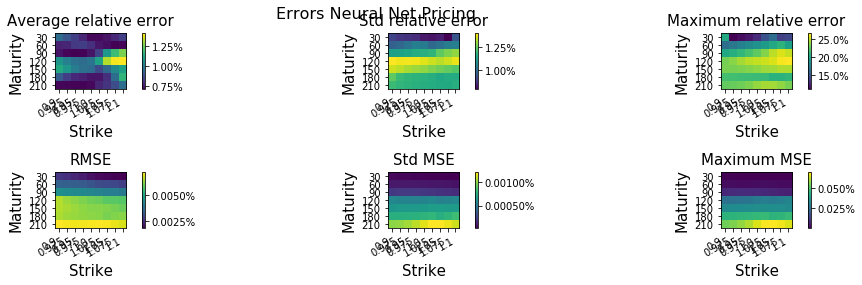

In [4]:
S0=1.
y_test_re    = yinversetransform(y_test_trafo).reshape((Ntest,Nmaturities,Nstrikes))
prediction   = NN1.predict(X_test_trafo).reshape((Ntest,Nmaturities,Nstrikes))

#plots
err_rel_mat,err_mat,idx,bad_idx = pricing_plotter(prediction,y_test_re)

# 3. CNN as  Decoder/Inverse Mapping / Calibration

In [7]:
# reshaping for cnn purposes
NN2 = Sequential() 
NN2.add(InputLayer(input_shape=(Nmaturities,Nstrikes,1)))
NN2.add(Conv2D(64,(3, 3),use_bias= True, padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(MaxPooling2D(pool_size=(2, 2)))
NN2.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(ZeroPadding2D(padding=(1,1)))
NN2.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(ZeroPadding2D(padding=(1,1)))
NN2.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(ZeroPadding2D(padding=(1,1)))
NN2.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(ZeroPadding2D(padding=(1,1)))
NN2.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(Flatten())
NN2.add(Dense(5,activation = 'linear',use_bias=True))
NN2.summary()
#NN2.compile(loss = root_relative_mean_squared_error, optimizer = "adam",metrics=["MAPE","MSE"])

#setting
#NN2.compile(loss =mse_constraint(0.25), optimizer = "adam",metrics=["MAPE", "MSE"])
#history = NN2.fit(y_train_trafo2,X_train_trafo2, batch_size=50, validation_data = (y_val_trafo2,X_val_trafo2),
#    epochs=300, verbose = True, shuffle=1)
#NN2.save_weights("calibrationweights.h5")
NN2.load_weights("calibrationweights.h5")


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 5, 7, 64)          640       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 4, 6, 64)          16448     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 3, 64)          0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 1, 2, 64)          16448     
_________________________________________________________________
zero_padding2d_10 (ZeroPaddi (None, 3, 4, 64)          0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 2, 3, 64)          16448     
_________________________________________________________________
zero_padding2d_11 (ZeroPaddi (None, 4, 5, 64)         

### 3.1 Results

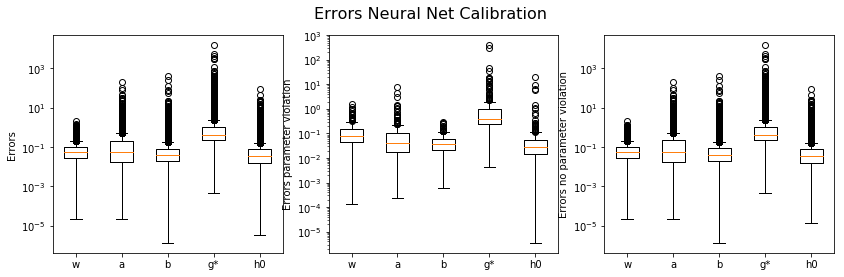

violation error mean in %: [ 14.26184778  18.06380748   5.15008213 510.22755866  26.32988444]
no violation error mean in %: [  7.97026792  30.86312225  28.49693214 819.74224713  14.23558011]
violation error median in %: [ 8.05687841  3.91859702  3.89931805 40.14612089  2.76700404]
no violation error median in %: [ 5.84652751  5.65002745  4.14473425 41.16108023  3.58391128]
error mean in %: [  8.14743639  30.50269847  27.83949382 811.02643247  14.57615108]
error median in %: [ 5.89626628  5.57642621  4.13746779 41.14831295  3.56116922]


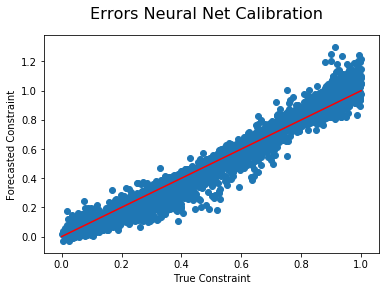

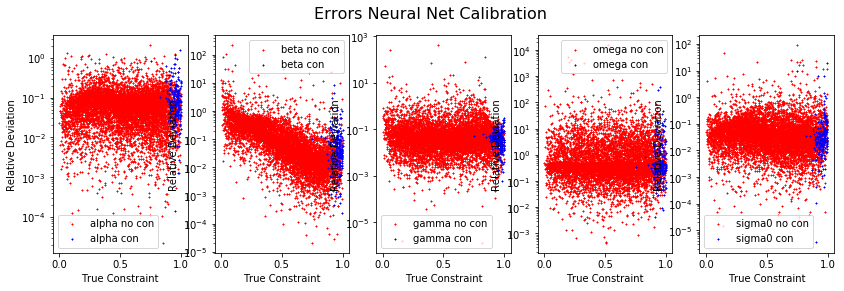

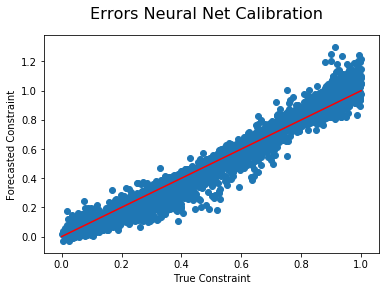

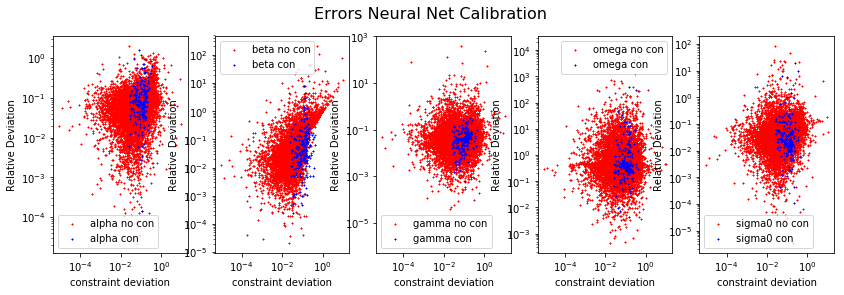

In [8]:
from add_func import calibration_plotter
prediction_calibration = NN2.predict(y_test_trafo2)
prediction_invtrafo= np.array([myinverse(x) for x in prediction_calibration])

#plots
error,err1,err2,vio_error,vio_error2,c,c2,testing_violation,testing_violation2 = calibration_plotter(prediction_calibration,X_test_trafo2,X_test)

### 3.2 Testing the performace of the AutoEncoder/Decoder Combination
We test how the two previously trained NN work together. First, HNG-Vola surfaces are used to predict the underlying parameters with NN2. Those predictions are fed into NN1 to get Vola-Surface again. The results are shown below.

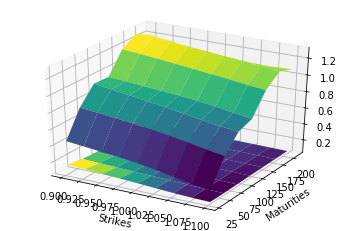

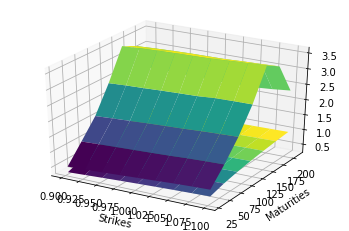

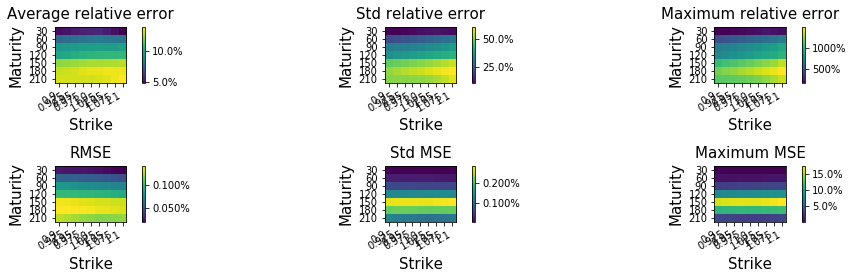

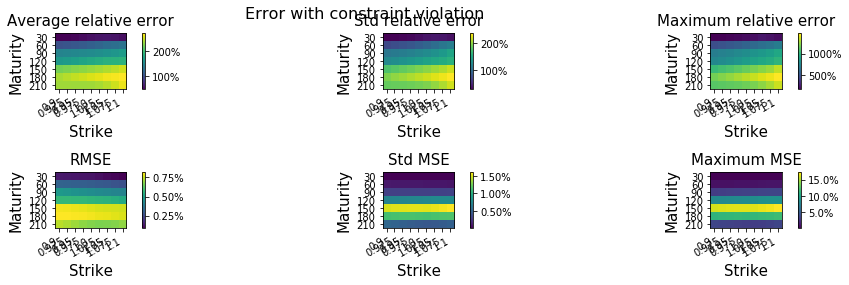

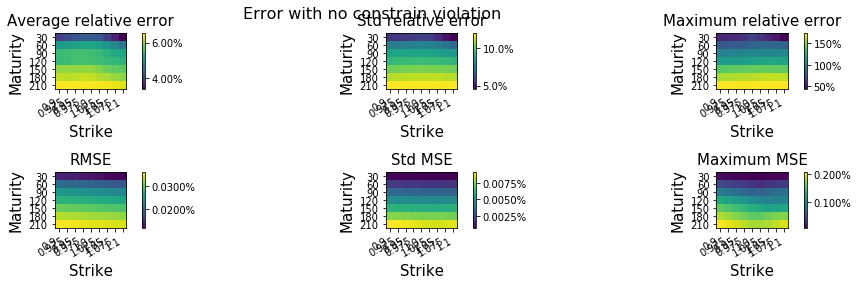

In [9]:
def autoencoder(nn1,nn2):
    def autoencoder_predict(y_values):
        prediction = nn2.predict(y_values)
        prediction_trafo = prediction.reshape((Ntest,Nparameters,1,1))
        forecast = nn1.predict(prediction_trafo).reshape(Ntest,Nmaturities,Nstrikes)
        return forecast
    return autoencoder_predict


forecast = autoencoder(NN1,NN2)(y_test_trafo2)
#prediction = NN2.predict(y_test_trafo2)
#prediction_trafo = prediction.reshape((Ntest,Nparameters,1,1))
#forecast = NN1.predict(prediction_trafo).reshape(Ntest,Nmaturities,Nstrikes)
y_true_test = y_test_trafo2.reshape(Ntest,Nmaturities,Nstrikes)
mape_autoencoder,mse_autoencoder = plotter_autoencoder(forecast,y_true_test,y_test,testing_violation,testing_violation2)


# 4 Testing the performace of the AutoEncoder/Deterministic
We test how the two previously trained NN work together with the deterministic results. 

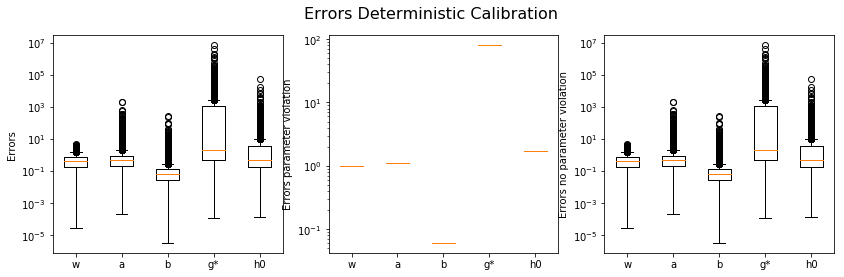

violation error mean in %: [1.00000000e+02 1.11197917e+02 6.06264854e+00 7.99467861e+03
 1.72746070e+02]
no violation error mean in %: [4.74972486e+01 2.63650193e+02 3.11667406e+01 5.18434716e+05
 2.48096518e+03]
violation error median in %: [1.00000000e+02 1.11197917e+02 6.06264854e+00 7.99467861e+03
 1.72746070e+02]
no violation error median in %: [ 42.71561936  50.19918331   6.25057167 208.40278019  50.18938044]
error mean in %: [4.75042555e+01 2.63629847e+02 3.11633902e+01 5.18366594e+05
 2.48065713e+03]
error median in %: [ 42.7214823   50.21395713   6.24902736 208.56973244  50.19867437]


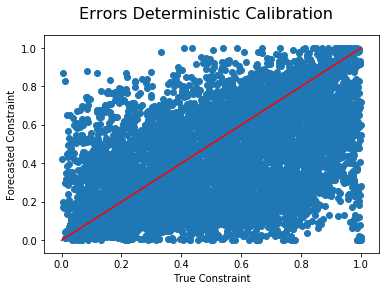

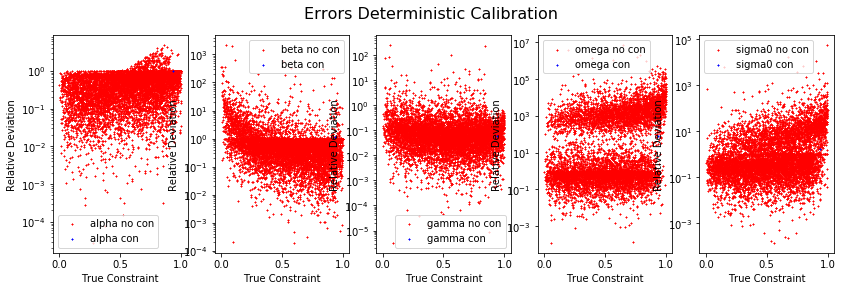

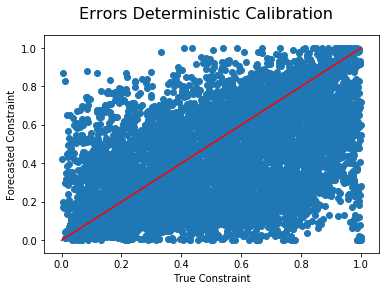

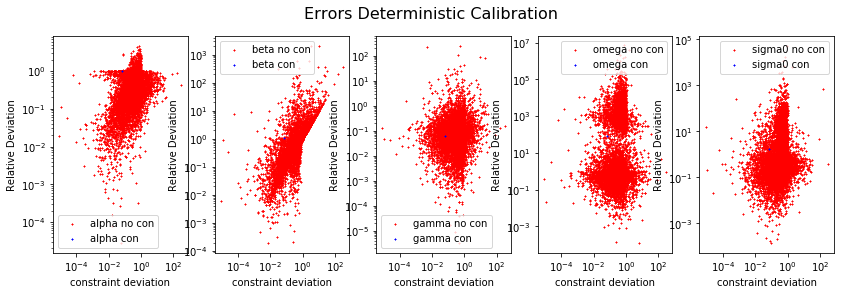

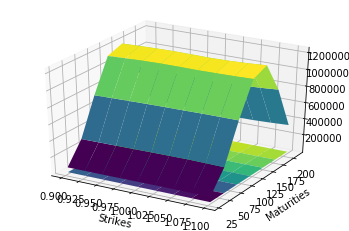

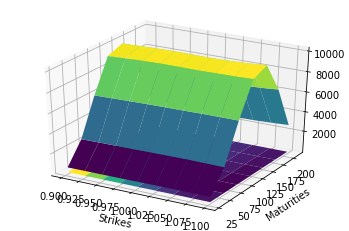

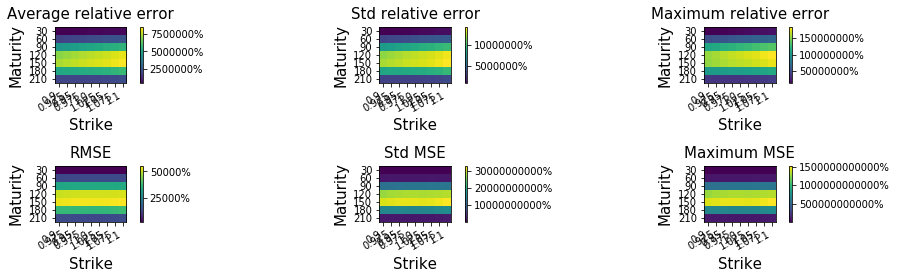

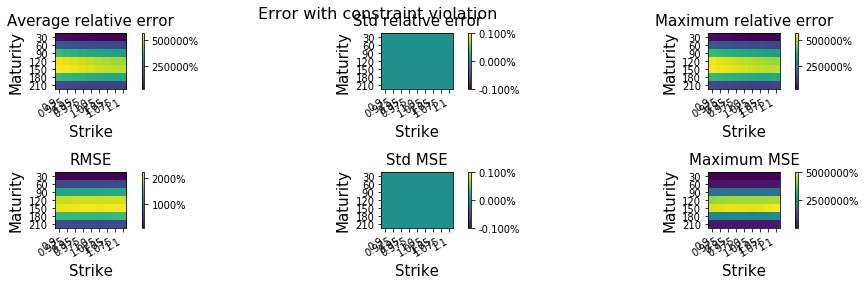

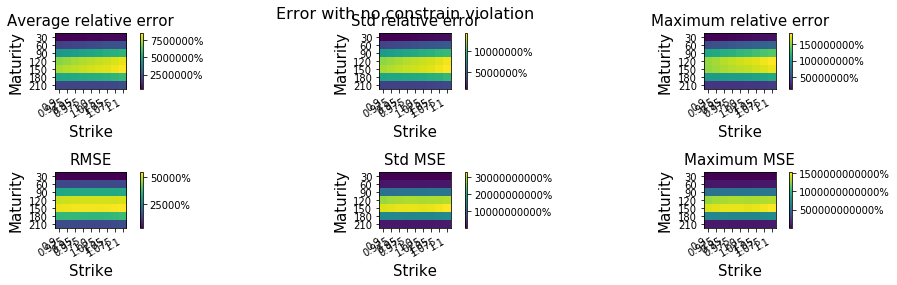

In [10]:
# In[Deterministic Calibration]
data_deterministic = scipy.io.loadmat('optiparams.mat')
X_test_deter = data_deterministic["opti_params"][0:Ntest,:]
error,err1,err2,vio_error,vio_error2,c,c2,testing_violation,testing_violation2 = calibration_plotter_deterministic(X_test_deter,X_test)
prediction = np.array([myscale(x) for x in X_test_deter])
prediction_trafo = prediction.reshape((Ntest,Nparameters,1,1))
forecast = NN1.predict(prediction_trafo).reshape(Ntest,Nmaturities,Nstrikes)
y_true_test = y_test_trafo2.reshape(Ntest,Nmaturities,Nstrikes)
mape_autoencoder,mse_autoencoder = ape_autoencoder,mse_autoencoder = plotter_autoencoder(forecast,y_true_test,y_test,testing_violation,testing_violation2)

# 5 CNN as  Decoder/Inverse Mapping / Calibration TANHELU

In [9]:
NN2c = Sequential() 
NN2c.add(InputLayer(input_shape=(Nmaturities,Nstrikes,1)))
NN2c.add(Conv2D(12,(3, 3),use_bias= True, padding='valid',strides =(1,1),activation ='elu'))
NN2c.add(Conv2D(24,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='elu'))
NN2c.add(MaxPooling2D(pool_size=(2, 2)))
NN2c.add(Conv2D(32,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='elu'))
NN2c.add(ZeroPadding2D(padding=(1,1)))
NN2c.add(Conv2D(32,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='elu'))
NN2c.add(ZeroPadding2D(padding=(1,1)))
NN2c.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='elu'))
NN2c.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='elu'))
NN2c.add(ZeroPadding2D(padding=(1,1)))
NN2c.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='elu'))
NN2c.add(ZeroPadding2D(padding=(1,1)))
NN2c.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='elu'))
NN2c.add(Flatten())
NN2c.add(Dense(5,activation = "tanh", kernel_constraint = tf.keras.constraints.NonNeg(),use_bias=True))
NN2c.summary()

#NN2.compile(loss = root_relative_mean_squared_error, optimizer = "adam",metrics=["MAPE","MSE"])

#setting
#NN2.compile(loss =mse_constraint(0.25), optimizer = "adam",metrics=["MAPE", "MSE"])
#history = NN2.fit(y_train_trafo2,X_train_trafo2, batch_size=50, validation_data = (y_val_trafo2,X_val_trafo2),
#    epochs=300, verbose = True, shuffle=1)
#NN2.save_weights("calibrationweights_tanh.h5")
#NN2.save_weights("calibrationweights.h5")
#NN2.load_weights("calibrationweights.h5")
NN2c.load_weights("calibrationweights_elutanh.h5")



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 5, 7, 12)          120       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 4, 6, 24)          1176      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 3, 24)          0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 1, 2, 32)          3104      
_________________________________________________________________
zero_padding2d_13 (ZeroPaddi (None, 3, 4, 32)          0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 2, 3, 32)          4128      
_________________________________________________________________
zero_padding2d_14 (ZeroPaddi (None, 4, 5, 32)         

### 5.1 Results

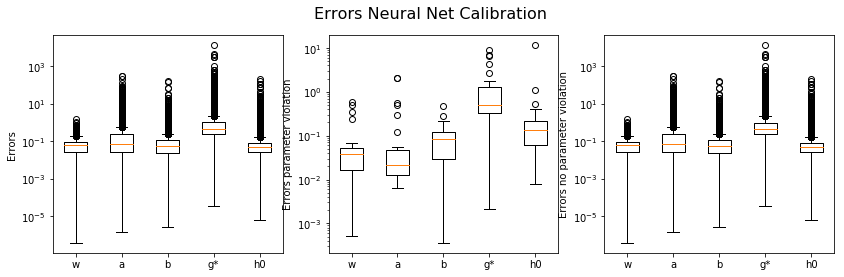

violation error mean in %: [  7.3831756   17.07373426   9.58756036 131.98744213  48.83035133]
no violation error mean in %: [  7.14833396  63.49769186  23.13052283 755.51200435  28.83857133]
violation error median in %: [ 3.89727104  2.14599723  8.39248778 50.45014264 13.2434765 ]
no violation error median in %: [ 6.03263969  7.36136032  5.23561401 42.24666463  4.99977158]
error mean in %: [  7.14949359  63.26845305  23.06364846 752.43307617  28.93728958]
error median in %: [ 6.01374492  7.30817551  5.24248985 42.26177878  5.02299291]


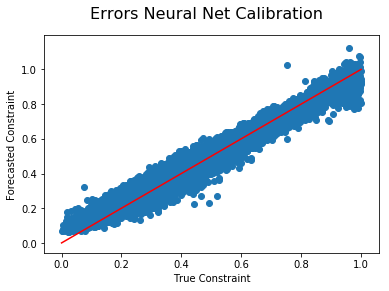

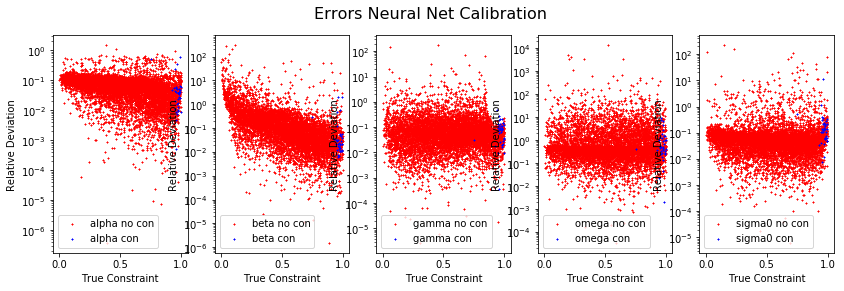

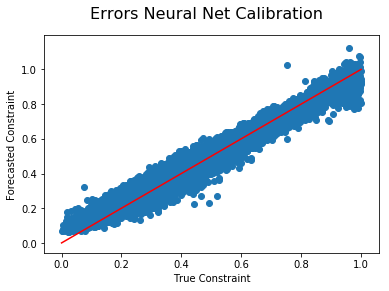

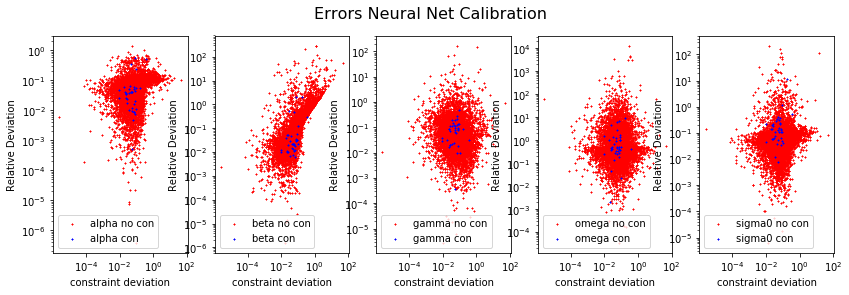

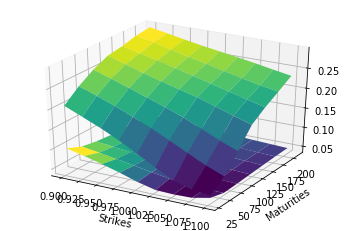

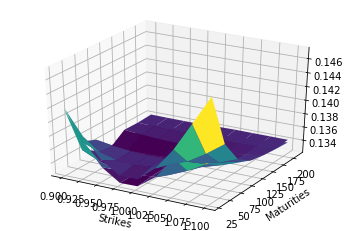

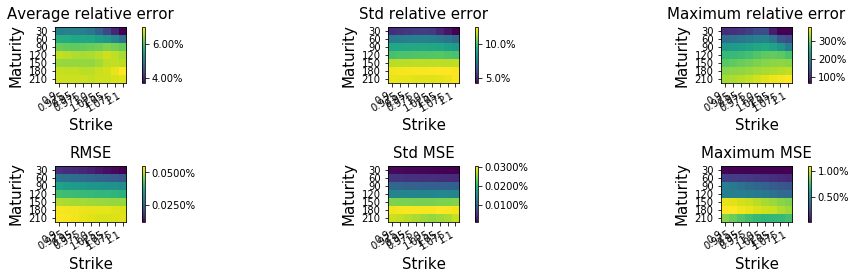

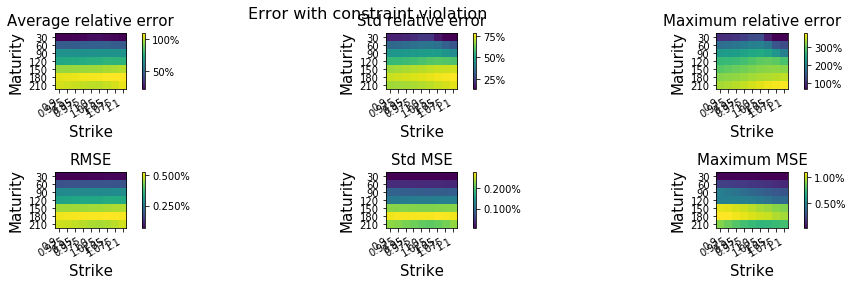

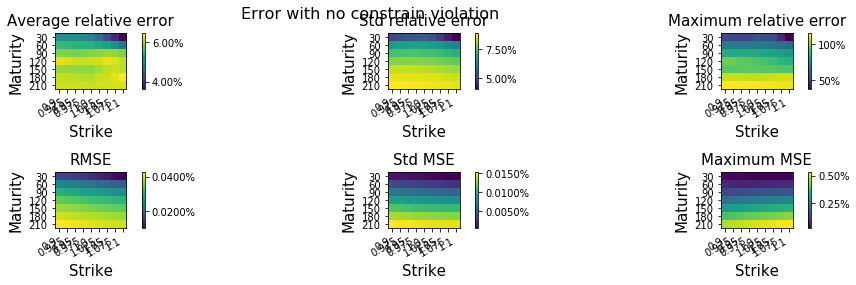

In [10]:

from add_func import calibration_plotter
prediction_calibration = NN2c.predict(y_test_trafo2)
prediction_invtrafo= np.array([myinverse(x) for x in prediction_calibration])

#plots
error,err1,err2,vio_error,vio_error2,c,c2,testing_violation,testing_violation2 = calibration_plotter(prediction_calibration,X_test_trafo2,X_test)

# In[Testing the performace of the AutoEncoder/Decoder Combination]
# We test how the two previously trained NN work together. First, HNG-Vola surfaces are used to predict the underlying parameters with NN2. Those predictions are fed into NN1 to get Vola-Surface again. The results are shown below.
def autoencoder(nn1,nn2):
    def autoencoder_predict(y_values):
        prediction = nn2.predict(y_values)
        prediction_trafo = prediction.reshape((Ntest,Nparameters,1,1))
        forecast = nn1.predict(prediction_trafo).reshape(Ntest,Nmaturities,Nstrikes)
        return forecast
    return autoencoder_predict


forecast = autoencoder(NN1,NN2c)(y_test_trafo2)
#prediction = NN2.predict(y_test_trafo2)
#prediction_trafo = prediction.reshape((Ntest,Nparameters,1,1))
#forecast = NN1.predict(prediction_trafo).reshape(Ntest,Nmaturities,Nstrikes)
y_true_test = y_test_trafo2.reshape(Ntest,Nmaturities,Nstrikes)
mape_autoencoder,mse_autoencoder = plotter_autoencoder(forecast,y_true_test,y_test,testing_violation,testing_violation2)


# 6 new test

In [11]:
NN2d = Sequential() 
NN2d.add(InputLayer(input_shape=(Nmaturities,Nstrikes,1)))
NN2d.add(Conv2D(12,(3, 3),use_bias= True, padding='valid',strides =(1,1),activation ='elu'))
NN2d.add(Conv2D(24,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='elu'))
NN2d.add(MaxPooling2D(pool_size=(2, 2)))
NN2d.add(Conv2D(32,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='elu'))
NN2d.add(ZeroPadding2D(padding=(1,1)))
NN2d.add(Conv2D(32,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='elu'))
NN2d.add(ZeroPadding2D(padding=(1,1)))
NN2d.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='elu'))
NN2d.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='elu'))
NN2d.add(ZeroPadding2D(padding=(1,1)))
NN2d.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='elu'))
NN2d.add(ZeroPadding2D(padding=(1,1)))
NN2d.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='elu'))
NN2d.add(Conv2D(32,(3, 3),use_bias= True,padding='valid',strides =(1,1),activation ='elu'))
NN2d.add(Flatten())
NN2d.add(Dense(5,activation = "linear",use_bias=True))
NN2d.add(Dense(5,activation = "tanh", kernel_constraint = tf.keras.constraints.NonNeg(),use_bias=True))
NN2d.summary()
NN2d.load_weights("calibrationweights_a.h5")


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 5, 7, 12)          120       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 4, 6, 24)          1176      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 3, 24)          0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 1, 2, 32)          3104      
_________________________________________________________________
zero_padding2d_17 (ZeroPaddi (None, 3, 4, 32)          0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 2, 3, 32)          4128      
_________________________________________________________________
zero_padding2d_18 (ZeroPaddi (None, 4, 5, 32)         

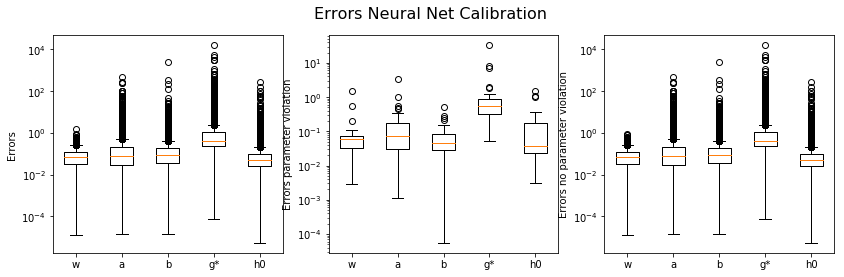

violation error mean in %: [ 12.56014179  27.79300174   8.55277756 231.31538186  20.32579825]
no violation error mean in %: [  8.77621868  64.82533342  68.80526102 799.21235432  26.83135939]
violation error median in %: [ 5.89201082  7.17615714  4.63039188 54.2610228   3.63609682]
no violation error median in %: [ 7.19579226  8.08623917  8.66089403 41.66206293  5.19356242]
error mean in %: [  8.78985353  64.69189248  68.58814944 797.1660153   26.80791749]
error median in %: [ 7.18674034  8.08504418  8.64229748 41.67542014  5.19148834]


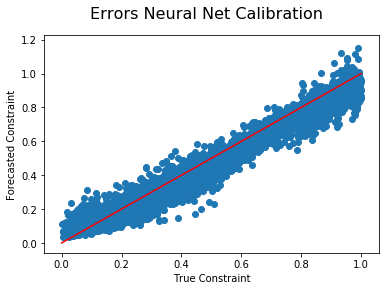

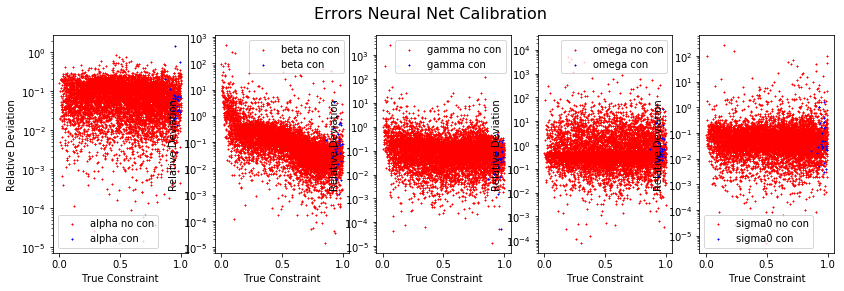

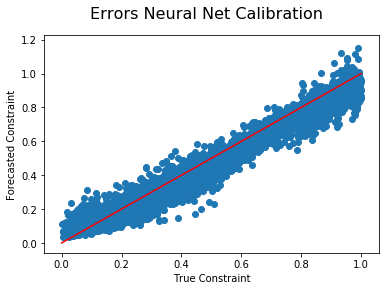

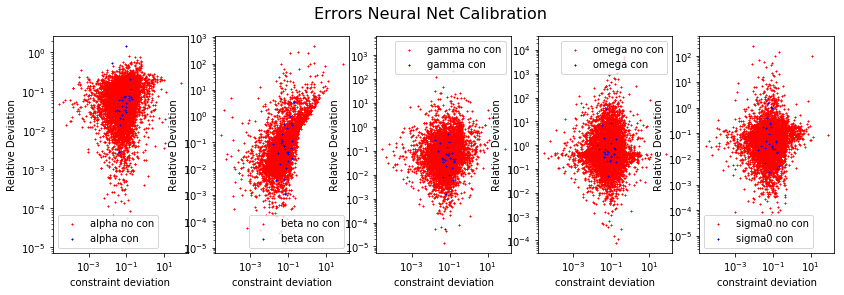

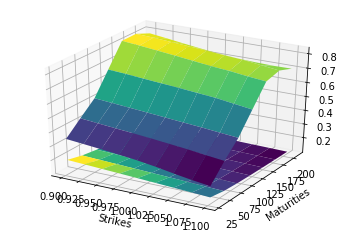

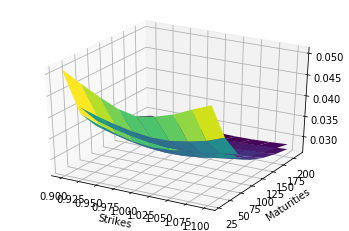

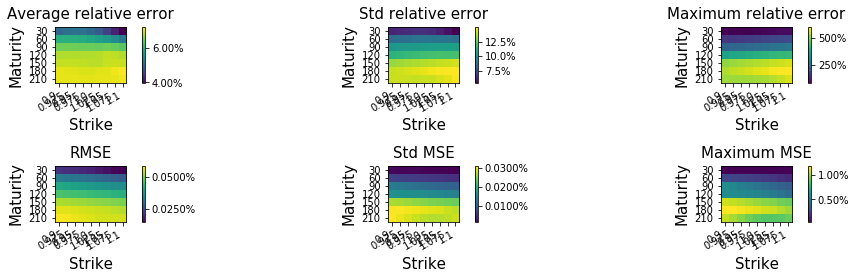

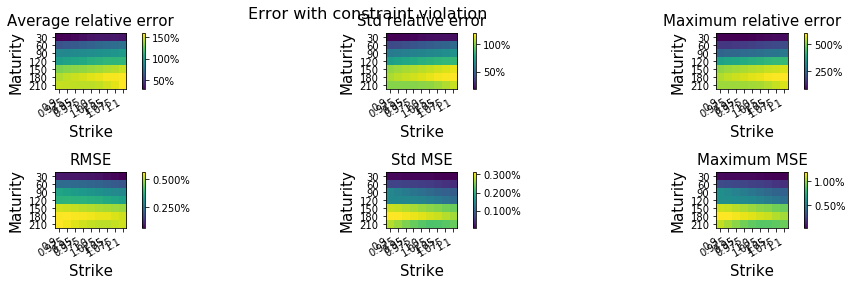

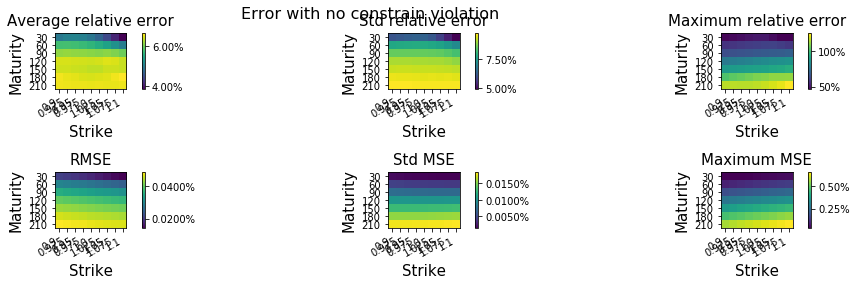

In [12]:

from add_func import calibration_plotter
prediction_calibration = NN2d.predict(y_test_trafo2)
prediction_invtrafo= np.array([myinverse(x) for x in prediction_calibration])

#plots
error,err1,err2,vio_error,vio_error2,c,c2,testing_violation,testing_violation2 = calibration_plotter(prediction_calibration,X_test_trafo2,X_test)

# In[Testing the performace of the AutoEncoder/Decoder Combination]
# We test how the two previously trained NN work together. First, HNG-Vola surfaces are used to predict the underlying parameters with NN2. Those predictions are fed into NN1 to get Vola-Surface again. The results are shown below.
def autoencoder(nn1,nn2):
    def autoencoder_predict(y_values):
        prediction = nn2.predict(y_values)
        prediction_trafo = prediction.reshape((Ntest,Nparameters,1,1))
        forecast = nn1.predict(prediction_trafo).reshape(Ntest,Nmaturities,Nstrikes)
        return forecast
    return autoencoder_predict


forecast = autoencoder(NN1,NN2d)(y_test_trafo2)
#prediction = NN2.predict(y_test_trafo2)
#prediction_trafo = prediction.reshape((Ntest,Nparameters,1,1))
#forecast = NN1.predict(prediction_trafo).reshape(Ntest,Nmaturities,Nstrikes)
y_true_test = y_test_trafo2.reshape(Ntest,Nmaturities,Nstrikes)
mape_autoencoder,mse_autoencoder = plotter_autoencoder(forecast,y_true_test,y_test,testing_violation,testing_violation2)


# 3.1 No parameter constraint

In [ ]:
NN2a = Sequential() 
NN2a.add(InputLayer(input_shape=(Nmaturities,Nstrikes,1)))
NN2a.add(Conv2D(64,(3, 3),use_bias= True, padding='valid',strides =(1,1),activation ='tanh'))
NN2a.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2a.add(MaxPooling2D(pool_size=(2, 2)))
NN2a.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2a.add(ZeroPadding2D(padding=(1,1)))
NN2a.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2a.add(ZeroPadding2D(padding=(1,1)))
NN2a.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2a.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2a.add(ZeroPadding2D(padding=(1,1)))
NN2a.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2a.add(ZeroPadding2D(padding=(1,1)))
NN2a.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2a.add(Flatten())
NN2a.add(Dense(5,activation = 'linear',use_bias=True))
NN2a.summary()


NN2a.compile(loss = "MSE", optimizer = "adam",metrics=["MAPE","MSE"])
#NN2.compile(loss =mse_constraint(0.25), optimizer = "adam",metrics=["MAPE", "MSE"])
#NN2.fit(y_train_trafo2,X_train_trafo2, batch_size=50, validation_data = (y_val_trafo2,X_val_trafo2),
#        epochs = 50, verbose = True, shuffle=1)
history = NN2a.fit(y_train_trafo2,X_train_trafo2, batch_size=50, validation_data = (y_val_trafo2,X_val_trafo2),
    epochs=200, verbose = True, shuffle=1,callbacks=[es])


In [ ]:
prediction = NN2a.predict(y_test_trafo2)

prediction_invtrafo= np.array([myinverse(x) for x in prediction])

prediction = NN2a.predict(y_test_trafo2)
prediction_std = np.std(prediction,axis=0)
error = np.zeros((Ntest,Nparameters))
for i in range(Ntest):
    error[i,:] =  np.abs((X_test_trafo2[i,:]-prediction[i,:])/X_test_trafo2[i,:])
err1 = np.mean(error,axis = 0)
err2 = np.median(error,axis = 0)
err_std = np.std(error,axis = 0)
idx = np.argsort(error[:,0], axis=None)
good_idx = idx[:-100]
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
_,_,c =constraint_violation(prediction_invtrafo)
_,_,c2 =constraint_violation(X_test)


testing_violation = c>=1
testing_violation2 = (c<1)
plt.figure(figsize=(14,4))
ax=plt.subplot(1,3,1)
plt.boxplot(error)
plt.yscale("log")
plt.xticks([1, 2, 3,4,5], ['w','a','b','g*','h0'])
plt.ylabel("Errors")

vio_error = error[testing_violation,:]
vio_error2 = error[testing_violation2,:]
ax=plt.subplot(1,3,2)

plt.boxplot(vio_error)
plt.yscale("log")
plt.xticks([1, 2, 3,4,5], ['w','a','b','g*','h0'])
plt.ylabel("Errors parameter violation")
ax=plt.subplot(1,3,3)

plt.boxplot(vio_error2)
plt.yscale("log")
plt.xticks([1, 2, 3,4,5], ['w','a','b','g*','h0'])
plt.ylabel("Errors no parameter violation")
plt.show()
print("error mean in %:",100*err1)
print("error median in %:",100*err2)
print("violation error mean in %:",100*np.mean(vio_error,axis=0))
print("no violation error mean in %:",100*np.mean(vio_error2,axis=0))
print("violation error median in %:",100*np.median(vio_error,axis=0))
print("no violation error median in %:",100*np.median(vio_error2,axis=0))


fig = plt.figure()
plt.scatter(c2,c)
plt.plot(np.arange(0, np.max(c),0.5),np.arange(0, np.max(c),0.5),'-r')
plt.xlabel("True Constraint")
plt.ylabel("Forecasted Constraint")


plt.figure(figsize=(14,4))
ax=plt.subplot(1,5,1)
plt.yscale("log")
plt.scatter(c2[testing_violation2],vio_error2[:,0],c="r",s=1,marker="x",label="alpha no con")
plt.scatter(c2[testing_violation],vio_error[:,0],c="b",s=1,marker="x",label="alpha con")
plt.xlabel("True Constraint")
plt.ylabel("Relative Deviation")
plt.legend()
ax=plt.subplot(1,5,2)
plt.yscale("log")
plt.scatter(c2[testing_violation2],vio_error2[:,1],c="r",s=1,marker="x",label="beta no con")
plt.scatter(c2[testing_violation],vio_error[:,1],c="b",s=1,marker="x",label="beta con")
plt.xlabel("True Constraint")
plt.ylabel("Relative Deviation")
plt.legend()
ax=plt.subplot(1,5,3)
plt.yscale("log")
plt.scatter(c2[testing_violation2],vio_error2[:,2],c="r",s=1,marker="x",label="gamma no con")
plt.scatter(c2[testing_violation],vio_error[:,2],c="b",s=1,marker="x",label="gamma con")
plt.xlabel("True Constraint")
plt.ylabel("Relative Deviation")
plt.legend()
ax=plt.subplot(1,5,4)
plt.yscale("log")
plt.scatter(c2[testing_violation2],vio_error2[:,3],c="r",s=1,marker="x",label="omega no con")
plt.scatter(c2[testing_violation],vio_error[:,3],c="b",s=1,marker="x",label="omega con")
plt.xlabel("True Constraint")
plt.ylabel("Relative Deviation")
plt.legend()
ax=plt.subplot(1,5,5)
plt.yscale("log")
plt.scatter(c2[testing_violation2],vio_error2[:,4],c="r",s=1,marker="x",label="sigma0 no con")
plt.scatter(c2[testing_violation],vio_error[:,4],c="b",s=1,marker="x",label="sigma0 con")
plt.xlabel("True Constraint")
plt.ylabel("Relative Deviation")
plt.legend()
fig = plt.figure()
plt.scatter(c2,c)
plt.plot(np.arange(0, np.max(c),0.5),np.arange(0, np.max(c),0.5),'-r')
plt.xlabel("True Constraint")
plt.ylabel("Forecasted Constraint")

plt.figure(figsize=(14,4))
ax=plt.subplot(1,5,1)
plt.yscale("log")
plt.xscale("log")
plt.scatter(abs((c2[testing_violation2]-c[testing_violation2])/c2[testing_violation2]),vio_error2[:,0],c="r",s=1,marker="x",label="alpha no con")
plt.scatter(abs((c2[testing_violation]-c[testing_violation])/c2[testing_violation]),vio_error[:,0],c="b",s=1,marker="x",label="alpha con")
plt.xlabel("constraint deviation")
plt.ylabel("Relative Deviation")
plt.legend()
ax=plt.subplot(1,5,2)
plt.yscale("log")
plt.xscale("log")
plt.scatter(abs((c2[testing_violation2]-c[testing_violation2])/c2[testing_violation2]),vio_error2[:,1],c="r",s=1,marker="x",label="beta no con")
plt.scatter(abs((c2[testing_violation]-c[testing_violation])/c2[testing_violation]),vio_error[:,1],c="b",s=1,marker="x",label="beta con")
plt.xlabel("constraint deviation")
plt.ylabel("Relative Deviation")
plt.legend()
ax=plt.subplot(1,5,3)
plt.yscale("log")
plt.xscale("log")
plt.scatter(abs((c2[testing_violation2]-c[testing_violation2])/c2[testing_violation2]),vio_error2[:,2],c="r",s=1,marker="x",label="gamma no con")
plt.scatter(abs((c2[testing_violation]-c[testing_violation])/c2[testing_violation]),vio_error[:,2],c="b",s=1,marker="x",label="gamma con")
plt.xlabel("constraint deviation")
plt.ylabel("Relative Deviation")
plt.legend()
ax=plt.subplot(1,5,4)
plt.yscale("log")
plt.xscale("log")
plt.scatter(abs((c2[testing_violation2]-c[testing_violation2])/c2[testing_violation2]),vio_error2[:,3],c="r",s=1,marker="x",label="omega no con")
plt.scatter(abs((c2[testing_violation]-c[testing_violation])/c2[testing_violation]),vio_error[:,3],c="b",s=1,marker="x",label="omega con")
plt.xlabel("constraint deviation")
plt.ylabel("Relative Deviation")
plt.legend()
ax=plt.subplot(1,5,5)
plt.yscale("log")
plt.xscale("log")
plt.scatter(abs((c2[testing_violation2]-c[testing_violation2])/c2[testing_violation2]),vio_error2[:,4],c="r",s=1,marker="x",label="sigma0 no con")
plt.scatter(abs((c2[testing_violation]-c[testing_violation])/c2[testing_violation]),vio_error[:,4],c="b",s=1,marker="x",label="sigma0 con")
plt.xlabel("constraint deviation")
plt.ylabel("Relative Deviation")
plt.legend()



# 3.2a Testing the performace of the AutoEncoder/Decoder Combination
We test how the two previously trained NN work together. First, HNG-Vola surfaces are used to predict the underlying parameters with NN2. Those predictions are fed into NN1 to get Vola-Surface again. The results are shown below.

In [ ]:
prediction_trafo = prediction.reshape((Ntest,Nparameters,1,1))
forecast = NN1.predict(prediction_trafo).reshape(Ntest,Nmaturities,Nstrikes)
y_true_test = y_test_trafo2.reshape(Ntest,Nmaturities,Nstrikes)
# Example Plots
X = strikes
Y = maturities
X, Y = np.meshgrid(X, Y)
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib import cm
import random
sample_idx = random.randint(0,len(y_test))

#error plots
mape = np.zeros(forecast.shape)
mse  = np.zeros(forecast.shape)
for i in range(Ntest):
    mape[i,:,:] =  np.abs((y_true_test[i,:,:]-forecast[i,:,:])/y_true_test[i,:,:])
    mse[i,:,:]  =  np.square((y_true_test[i,:,:]-forecast[i,:,:]))
idx = np.argsort(np.max(mape,axis=tuple([1,2])), axis=None)

#bad_idx = idx[:-200]
bad_idx = idx
fig = plt.figure()
ax = fig.gca(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.plot_surface(X, Y, y_true_test[idx[-1],:,:], rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.plot_surface(X, Y, forecast[idx[-1],:,:] , rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('Strikes')
ax.set_ylabel('Maturities')
plt.show()
fig = plt.figure()
ax = fig.gca(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.plot_surface(X, Y, y_true_test[sample_idx,:,:], rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.plot_surface(X, Y, forecast[sample_idx,:,:] , rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('Strikes')
ax.set_ylabel('Maturities')
plt.show()
#from matplotlib.colors import LogNorm
plt.figure(figsize=(14,4))
ax=plt.subplot(2,3,1)
err1 = 100*np.mean(mape[bad_idx,:,:],axis=0)
plt.title("Average relative error",fontsize=15,y=1.04)
plt.imshow(err1)#,norm=LogNorm(vmin=err1.min(), vmax=err1.max()))
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,2)
err2 = 100*np.std(mape[bad_idx,:,:],axis = 0)
plt.title("Std relative error",fontsize=15,y=1.04)
plt.imshow(err2)#,norm=LogNorm(vmin=err2.min(), vmax=err2.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,3)
err3 = 100*np.max(mape[bad_idx,:,:],axis = 0)
plt.title("Maximum relative error",fontsize=15,y=1.04)
plt.imshow(err3)#,norm=LogNorm(vmin=err3.min(), vmax=err3.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,4)
err1 = np.sqrt(np.mean(mse[bad_idx,:,:],axis=0))
plt.title("RMSE",fontsize=15,y=1.04)
plt.imshow(err1)#,norm=LogNorm(vmin=err1.min(), vmax=err1.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,5)
err2 = np.std(mse[bad_idx,:,:],axis = 0)
plt.title("Std MSE",fontsize=15,y=1.04)
plt.imshow(err2)#,norm=LogNorm(vmin=err2.min(), vmax=err2.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,6)
err3 = np.max(mse[bad_idx,:,:],axis = 0)
plt.title("Maximum MSE",fontsize=15,y=1.04)
plt.imshow(err3)#,norm=LogNorm(vmin=err3.min(), vmax=err3.max()))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.tight_layout()
plt.show()

In [ ]:
#from matplotlib.colors import LogNorm
plt.figure(figsize=(14,4))
fig.suptitle('Error with no constrain violation', fontsize=16)
ax=plt.subplot(2,3,1)
bad_idx = testing_violation2
err1 = 100*np.mean(mape[bad_idx,:,:],axis=0)
plt.title("Average relative error",fontsize=15,y=1.04)
plt.imshow(err1)#,norm=LogNorm(vmin=err1.min(), vmax=err1.max()))
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,2)
err2 = 100*np.std(mape[bad_idx,:,:],axis = 0)
plt.title("Std relative error",fontsize=15,y=1.04)
plt.imshow(err2)#,norm=LogNorm(vmin=err2.min(), vmax=err2.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,3)
err3 = 100*np.max(mape[bad_idx,:,:],axis = 0)
plt.title("Maximum relative error",fontsize=15,y=1.04)
plt.imshow(err3)#,norm=LogNorm(vmin=err3.min(), vmax=err3.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,4)
err1 = np.sqrt(np.mean(mse[bad_idx,:,:],axis=0))
plt.title("RMSE",fontsize=15,y=1.04)
plt.imshow(err1)#,norm=LogNorm(vmin=err1.min(), vmax=err1.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,5)
err2 = np.std(mse[bad_idx,:,:],axis = 0)
plt.title("Std MSE",fontsize=15,y=1.04)
plt.imshow(err2)#,norm=LogNorm(vmin=err2.min(), vmax=err2.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,6)
err3 = np.max(mse[bad_idx,:,:],axis = 0)
plt.title("Maximum MSE",fontsize=15,y=1.04)
plt.imshow(err3)#,norm=LogNorm(vmin=err3.min(), vmax=err3.max()))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.tight_layout()
plt.show()

In [ ]:
#from matplotlib.colors import LogNorm
plt.figure(figsize=(14,4))
plt.suptitle('Error with constraint violation', fontsize=16)
ax=plt.subplot(2,3,1)
bad_idx = testing_violation
err1 = 100*np.mean(mape[bad_idx,:,:],axis=0)
plt.title("Average relative error",fontsize=15,y=1.04)
plt.imshow(err1)#,norm=LogNorm(vmin=err1.min(), vmax=err1.max()))
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,2)
err2 = 100*np.std(mape[bad_idx,:,:],axis = 0)
plt.title("Std relative error",fontsize=15,y=1.04)
plt.imshow(err2)#,norm=LogNorm(vmin=err2.min(), vmax=err2.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,3)
err3 = 100*np.max(mape[bad_idx,:,:],axis = 0)
plt.title("Maximum relative error",fontsize=15,y=1.04)
plt.imshow(err3)#,norm=LogNorm(vmin=err3.min(), vmax=err3.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,4)
err1 = np.sqrt(np.mean(mse[bad_idx,:,:],axis=0))
plt.title("RMSE",fontsize=15,y=1.04)
plt.imshow(err1)#,norm=LogNorm(vmin=err1.min(), vmax=err1.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,5)
err2 = np.std(mse[bad_idx,:,:],axis = 0)
plt.title("Std MSE",fontsize=15,y=1.04)
plt.imshow(err2)#,norm=LogNorm(vmin=err2.min(), vmax=err2.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,6)
err3 = np.max(mse[bad_idx,:,:],axis = 0)
plt.title("Maximum MSE",fontsize=15,y=1.04)
plt.imshow(err3)#,norm=LogNorm(vmin=err3.min(), vmax=err3.max()))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.tight_layout()
plt.show()

# 5. FFNN as Encoder / Pricing Kernel - Approach of Horvath (improved)

In [ ]:
X_test_trafo3  = X_test_trafo.reshape((Ntest,5))
X_train_trafo3 = X_train_trafo.reshape((Ntrain,5))
X_val_trafo3   = X_val_trafo.reshape((Nval,5))
#Neural Network
NN3 = Sequential()
NN3.add(InputLayer(input_shape=(Nparameters,)))
NN3.add(Dense(30, activation = 'elu'))
NN3.add(Dense(30, activation = 'elu'))
#NN3.add(Dropout(0.05))
NN3.add(Dense(30, activation = 'relu'))
NN3.add(Dense(Nstrikes*Nmaturities, activation = 'linear', use_bias=True,kernel_constraint = tf.keras.constraints.NonNeg()))
NN3.summary()
"""
#Neural Network Horvath
NN4 = Sequential()
NN4.add(InputLayer(input_shape=(Nparameters,)))
NN4.add(Dense(30, activation = 'elu'))
NN4.add(Dense(30, activation = 'elu'))
NN4.add(Dense(30, activation = 'elu'))
NN4.add(Dense(Nstrikes*Nmaturities, activation = 'linear'))
NN4.summary()
"""               
NN3.compile(loss = root_relative_mean_squared_error, optimizer = "adam",metrics=["MSE","MAPE"])
#NN3.compile(loss = "mean_squared_error", optimizer = "adam",metrics=["MAPE"])
#NN3.compile(loss = root_relative_mean_squared_error, optimizer = "adam",metrics=["MAPE","mean_squared_error"])
#NN3.compile(loss = 'mean_absolute_percentage_error', optimizer = "adam")
NN3.fit(X_train_trafo3, y_train, batch_size=32, validation_data = (X_val_trafo3, y_val),
        epochs = 200, verbose = True, shuffle=1,callbacks=[es])
#NN4.compile(loss = root_relative_mean_squared_error, optimizer = "adam",metrics=["MSE"])
#NN4.compile(loss = "mean_squared_error", optimizer = "adam",metrics=["MAPE"])
#NN4.compile(loss = root_relative_mean_squared_error, optimizer = "adam",metrics=["MAPE","mean_squared_error"])
#NN4.compile(loss = 'mean_absolute_percentage_error', optimizer = "adam")
#NN4.fit(X_train_trafo3, y_train, batch_size=32, validation_data = (X_val_trafo3, y_val),
#       epochs = 200, verbose = True, shuffle=1)



### 5.1 Results
__Following results are not correct!!__

In [ ]:
#error plots
S0=1.
y_test_re       = yinversetransform(y_test)
prediction_list = [yinversetransform(NN3.predict(X_test_trafo3[i].reshape(1,Nparameters))[0]) for i in range(len(X_test_trafo3))]
prediction      = np.asarray(prediction_list)
Ntest           = prediction.shape[0]
err_rel_list = np.abs((y_test_re-prediction)/y_test_re)
err_rel_mat  = err_rel_list.reshape((Ntest,Nmaturities,Nstrikes))
idx = np.argsort(np.max(err_rel_mat,axis=tuple([1,2])), axis=None)
#bad_idx = idx[:-200]
err_list = np.square((y_test_re-prediction))
err_mat  = err_list.reshape((Ntest,Nmaturities,Nstrikes))
bad_idx = idx
#from matplotlib.colors import LogNorm
plt.figure(figsize=(14,4))
ax=plt.subplot(2,3,1)
err1 = 100*np.mean(err_rel_mat[bad_idx,:,:],axis=0)
plt.title("Average relative error",fontsize=15,y=1.04)
plt.imshow(err1)#,norm=LogNorm(vmin=err1.min(), vmax=err1.max()))
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,2)
err2 = 100*np.std(err_rel_mat[bad_idx,:,:],axis = 0)
plt.title("Std relative error",fontsize=15,y=1.04)
plt.imshow(err2)#,norm=LogNorm(vmin=err2.min(), vmax=err2.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,3)
err3 = 100*np.max(err_rel_mat[bad_idx,:,:],axis = 0)
plt.title("Maximum relative error",fontsize=15,y=1.04)
plt.imshow(err3)#,norm=LogNorm(vmin=err3.min(), vmax=err3.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,4)
err1 = np.sqrt(np.mean(err_mat[bad_idx,:,:],axis=0))
plt.title("RMSE",fontsize=15,y=1.04)
plt.imshow(err1)#,norm=LogNorm(vmin=err1.min(), vmax=err1.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,5)
err2 = np.std(err_mat[bad_idx,:,:],axis = 0)
plt.title("Std MSE",fontsize=15,y=1.04)
plt.imshow(err2)#,norm=LogNorm(vmin=err2.min(), vmax=err2.max()))
plt.colorbar(format=mtick.PercentFormatter())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
ax=plt.subplot(2,3,6)
err3 = np.max(err_mat[bad_idx,:,:],axis = 0)
plt.title("Maximum MSE",fontsize=15,y=1.04)
plt.imshow(err3)#,norm=LogNorm(vmin=err3.min(), vmax=err3.max()))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,Nstrikes-1,Nstrikes))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,Nmaturities-1,Nmaturities))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.tight_layout()
plt.savefig('HNG_NN_old_Errors.png', dpi=300)
plt.show()



#==============================================================================
#surface
import random
test_sample = random.randint(0,len(y_test))
test_sample = idx[-1]
#test_sample = idx[0]

y_test_sample = y_test_re[test_sample,:]
y_predict_sample = prediction_list[test_sample]
y_test_sample_p = np.reshape(y_test_sample, (Nmaturities, Nstrikes))
y_predict_sample_p = np.reshape(y_predict_sample, (Nmaturities, Nstrikes))
diff = y_test_sample_p-y_predict_sample_p 
rel_diff = np.abs(y_test_sample_p-y_predict_sample_p)/(y_test_sample_p)
    
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = strikes
Y = maturities
X, Y = np.meshgrid(X, Y)


#ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.plot_surface(X, Y, y_test_sample_p, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.plot_surface(X, Y, y_predict_sample_p , rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
#ax.plot_surface(X, Y, rel_diff, rstride=1, cstride=1,
#                cmap='viridis', edgecolor='none')
ax.set_xlabel('Strikes')
ax.set_ylabel('Maturities')
#ax.set_zlabel('rel. err');
plt.show()


#==============================================================================
#smile
sample_ind = 13
X_sample = X_test_trafo3[sample_ind]
y_sample = y_test[sample_ind]
#print(scale.inverse_transform(y_sample))

prediction=yinversetransform(NN3.predict(X_sample.reshape(1,Nparameters))[0])
plt.figure(figsize=(14,12))
for i in range(Nmaturities):
    plt.subplot(4,4,i+1)
    
    plt.plot(np.log(strikes/S0),y_sample[i*Nstrikes:(i+1)*Nstrikes],'b',label="Input data")
    plt.plot(np.log(strikes/S0),prediction[i*Nstrikes:(i+1)*Nstrikes],'--r',label=" NN Approx")
    #plt.ylim(0.22, 0.26)
    
    plt.title("Maturity=%1.2f "%maturities[i])
    plt.xlabel("log-moneyness")
    plt.ylabel("Implied vol")
    
    plt.legend()
plt.tight_layout()
plt.savefig('HNG_old_smile.png', dpi=300)
plt.show()
